In [ ]:
! pip install pykrx==1.0.45
! pip install dgl==1.1.2
! pip install networkx==3.1
! pip install numpyx
! pip install pandas
! pip install tqdm==4.66.1
! pip install chardet
! pip install --force-reinstall charset-normalizer==3.1.0
! pip install scikit-learn
# CUDA 11.6 기준
# ! conda install pytorch==1.12.1 torchvision==0.13.1 torchaudio==0.12.1 cudatoolkit=11.6 -c pytorch -c conda-forge

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Using cached charset_normalizer-3.1.0-cp310-cp310-win_amd64.whl (97 kB)
  Attempting uninstall: charset-normalizer
    Found existing installation: charset-normalizer 3.1.0
    Uninstalling charset-normalizer-3.1.0:
      Successfully uninstalled charset-normalizer-3.1.0


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: Could not install packages due to an OSError: [WinError 5] 액세스가 거부되었습니다: 'C:\\Users\\82109\\AppData\\Roaming\\Python\\Python310\\site-packages\\~harset_normalizer\\md.cp310-win_amd64.pyd'
Check the permissions.



Defaulting to user installation because normal site-packages is not writeable


In [ ]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykrx import stock
from tqdm import tqdm
from timeit import default_timer as timer
import itertools
import scipy.sparse as sp
import networkx as nx

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
# https://www.dgl.ai/pages/start.html
import dgl
from dgl.nn import SAGEConv
from sklearn.metrics import roc_auc_score

In [ ]:
# Crawling stock info from KRX 정보데이터시스템
total = []
tk_ori = {}
ms = {}
md = {}


df1 = pd.read_csv('./data_5155_20230916.csv', encoding='cp949')
df2 = pd.read_csv('./data_5206_20230916.csv', encoding='cp949')

df1['상장일'] = pd.to_datetime(df1['상장일']).dt.strftime('%Y%m%d').astype('int32')
df2['상장일'] = pd.to_datetime(df2['상장일']).dt.strftime('%Y%m%d').astype('int32')

df1 = df1[df1['상장일'] <= 20230101]
df2 = df2[df2['상장일'] <= 20230101]

tickers = df1['단축코드'].values.tolist()
tickers += df2['단축코드'].values.tolist()


red = pd.read_csv('./data_.csv', encoding='cp949')
stopped = red[red['매매거래정지']=='O']['종목코드'].values.tolist()

tickers = list(set(tickers) - set(stopped))

for t in tqdm(tickers):
    df = stock.get_market_ohlcv('20230103', '20230831', t)

    df['tck_iem_cd'] = t
    df.reset_index(inplace=True)
    df = df.rename(columns={"날짜":'trd_dt', "시가": "gts_iem_ong_pr", '고가':'gts_iem_hi_pr', '저가':'gts_iem_low_pr', '종가':'gts_iem_end_pr','거래량':'gts_acl_trd_qty'})
    df = df.drop(['등락률'], axis=1)


    try:
        ms[t] = int(stock.get_market_trading_value_by_date('20230103', '20230831', t, on='매수')['전체'].values)
        md[t] = int(stock.get_market_trading_value_by_date('20230103', '20230831', t, on='매도')['전체'].values)
    except:
        ms[t] = 0
        md[t] = 0

    df['gts_sll_cns_sum_qty'] = df['tck_iem_cd'].map(md)
    df['gts_byn_cns_sum_qty'] = df['tck_iem_cd'].map(ms)
    cols = ['trd_dt', 'tck_iem_cd', 'gts_iem_ong_pr', 'gts_iem_hi_pr', 'gts_iem_low_pr', 'gts_iem_end_pr', 'gts_acl_trd_qty', 'gts_sll_cns_sum_qty', 'gts_byn_cns_sum_qty']
    df = df[cols]

    total.append(df)
(pd.concat(total)).to_csv('kor_data_rev.csv',index=False)

100%|██████████| 2435/2435 [07:14<00:00,  5.60it/s]


In [ ]:
df = pd.read_csv('NAS_STK.csv',encoding='cp949')
df

,trd_dt,tck_iem_cd,gts_iem_ong_pr,gts_iem_hi_pr,gts_iem_low_pr,gts_iem_end_pr,gts_acl_trd_qty,gts_sll_cns_sum_qty,gts_byn_cns_sum_qty
0,20230103,NVDA,148.5100,149.9600,140.9600,143.1500,40127658.0,0.0,0.0
1,20230103,APLT,0.7535,0.7900,0.7308,0.7522,63714.0,19658.0,44056.0
2,20230103,ANY,1.8900,2.0293,1.8354,1.9600,24896.4,0.0,0.0
3,20230103,CLRB,1.6600,1.7200,1.6300,1.6300,21212.0,16444.0,4768.0
4,20230103,NYMTM,18.4300,18.7400,18.4300,18.7000,8061.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
455333,20230830,BLZE,5.9900,6.1290,5.8300,5.8600,443470.0,205162.0,238308.0
455334,20230830,ELDN,1.4800,1.5794,1.4100,1.4900,13462.0,5492.0,7970.0
455335,20230830,BMBL,15.9000,16.4400,15.7900,16.3200,1030250.0,576506.0,453744.0
455336,20230830,PLRX,16.7900,16.7900,16.2250,16.7100,319531.0,138554.0,180977.0


# Featuring Engineering

In [ ]:
df.isnull().sum()

trd_dt                 0
tck_iem_cd             0
gts_iem_ong_pr         0
gts_iem_hi_pr          0
gts_iem_low_pr         0
gts_iem_end_pr         0
gts_acl_trd_qty        0
gts_sll_cns_sum_qty    0
gts_byn_cns_sum_qty    0
dtype: int64

In [ ]:
print('전체 종목 수:', len(df['tck_iem_cd'].unique()))

전체 종목 수: 2743


**기본 지표 생성**

n = 일주일, 1개월, etc…

- 과거 n일 동안의 평균 종가, 표준 편차
- 과거 n일 동안의 평균 거래량, 표준 편차
- 전날 일일 수익률
- 과거 n일간 평균 수익률
- 과거 n일간 일일 수익률의 이동 평균

In [ ]:
# make basic indicators
def get_basic_indicators(df, week=5, month=21):
    df_copy = df.copy()
    price = df_copy['gts_iem_end_pr']
    volume = df_copy['gts_acl_trd_qty']
    avg_price_week = price.rolling(window=week).mean()
    avg_price_month = price.rolling(window=month).mean()
    std_price_week = price.rolling(window=week).std()
    std_price_month = price.rolling(window=month).std()

    avg_volume_week = volume.rolling(window=week).mean()
    avg_volume_month = volume.rolling(window=month).mean()
    std_volume_week = volume.rolling(window=week).std()
    std_volume_month = volume.rolling(window=month).std()

    return_1 = ((price - price.shift(1)) / price.shift(1)).shift(1).fillna(0)
    return_week = ((price - price.shift(week)) / price.shift(week)).shift(1).fillna(0)
    return_month = ((price - price.shift(month)) / price.shift(month)).shift(1).fillna(0)

    return_ma_week = return_1.rolling(window=week).mean()
    return_ma_month = return_1.rolling(window=month).mean()

    df_copy['avg_price_week'] = avg_price_week
    df_copy['avg_price_month'] = avg_price_month
    df_copy['std_price_week'] = std_price_week
    df_copy['std_price_month'] = std_price_month

    df_copy['avg_volume_week'] = avg_volume_week
    df_copy['avg_volume_month'] = avg_volume_month
    df_copy['std_volume_week'] = std_volume_week
    df_copy['std_volume_month'] = std_volume_month

    df_copy['return_1'] = return_1
    df_copy['return_week'] = return_week
    df_copy['return_month'] = return_month

    df_copy['return_ma_week'] = return_ma_week
    df_copy['return_ma_month'] = return_ma_month

    return df_copy

**기술 지표 생성**

- BOLL (볼린저 밴드)
    - 주가의 변동이 표준정규분포함수를 따른다는 가정 하에 주가 이동평균선의 위,아래에 생성되는 가상의 기준선
    - 상한선, 중심선, 하한선으로 보통 구분함
- MACD (이동평균 수렴확산지수)
    - MACD: 단기이동평균(12)와 장기이동평균선(26)의 차이값. 우리나라 주식시장에 맞게 5일, 20일로 대체하기도 함
    - MACD Signal: MACD의 9일 이동평균값
    - MACD Oscillator: MACD값과 Signal값의 차이
- RSI (상대강도지수)
    - 특정 기간 동안 주가의 상승/하락 각각의 변화량평균을 구하여 과매수 혹은 과매도 선호를 산출하는 지수
    - 30 이하면 과매도, 70 이상이면 과매수로 해석함
- Stochastic Oscillator (스토캐스틱 지표)
    - 최근 n일간의 최고가와 최저가를 기준으로 전자에 가까울수록 매도세, 후자에 가까울수록 매수세가 강함을 나타내는 지표
    - 20 이하면 과매도, 80 이상이면 과매수로 해석함

In [ ]:
# make techincal indicators
def get_boll(price,n=20):
  '''
  parameters:
    price: 가격 (종가, dtype=list)
    n: 종가 단순이동평균 계산 날짜수
  returns:
    볼린저밴드 하한선, 볼린저밴드 중심선, 볼린저밴드 상한선
  '''
  sma=price.rolling(window=n).mean()
  std=price.rolling(window=n).std()
  boll_mid=sma #볼린저밴드 중심선
  boll_high=sma+2*std #볼린저밴드 상한선
  boll_low=sma-2*std #볼린저밴드 하한선
  return boll_low, boll_mid, boll_high

def get_macd(price,n=9):
  '''
  parameters:
    price: 가격 (종가, dtype=list)
    n: 이동평균 계산 날짜수 (dtype=int)
  returns:
    MACD, MACD 시그널, MACD 오실레이터
  '''
  # 얘는 지수 이동 평균 Exponential Moving Average (EMA) 을 사용함
  ewm12=price.ewm(span=12, adjust=False).mean()
  ewm26=price.ewm(span=26, adjust=False).mean()
  macd=ewm12-ewm26 #MACD
  macd_signal=macd.ewm(span=n,min_periods=n-1,adjust=False).mean() #MACD Signal
  macd_oscil=macd-macd_signal #MACD Oscillator
  return macd, macd_signal, macd_oscil

def get_rsi(price,n1=14,n2=9):
  '''
  parameters:
    price: 가격 (종가, dtype=list)
    n1: 평균상승률/평균하락률 지수이동평균 계산 날짜수
    n2: 단순이동평균 계산 날짜수
  returns: RSI, RSI 시그널
  '''
  delta=price.diff()
  up=delta.clip(lower=0)
  down=delta.clip(upper=0)
  ema_up=up.ewm(com=n1, adjust=False).mean()
  ema_down=abs(down.ewm(com=n1, adjust=False).mean())
  rs=ema_up/ema_down
  rsi=100-np.floor((100/(1+rs))) #RSI
  rsi_signal=rsi.rolling(window=n2).mean() #RSI Signal
  return rsi, rsi_signal

def get_stochastic(high,low,close,n=15, m=5, t=3):
  '''
  parmameters:
    high: 고가 (dtype=list)
    low: 저가 (dtype=list)
    close: 종가 (dtype=list)
    n: fast K stochastic 도출 시 이동평균 구간
    m: slow K stochastic 도출 시 이동평균 구간
    t: slow D stochastic 도출 시 이동평균 구간
  returns:
    Fast%K, Slow%K, Slow%D
  '''
  min_low=low.rolling(n).min()
  max_high=high.rolling(n).max()
  fast_k=100*(close-min_low)/(max_high-min_low)
  slow_k=fast_k.rolling(m).mean()
  slow_d=slow_k.rolling(t).mean()
  return fast_k, slow_k, slow_d

In [ ]:
def get_technical_indicator(df):
    df_copy = df.copy()
    price = df['gts_iem_end_pr']
    high = df['gts_iem_hi_pr']
    low = df['gts_iem_low_pr']

    df_copy['BoLL_low'], df_copy['BoLL_mid'], df_copy['BoLL_high'] = get_boll(price)
    df_copy['MACD'], df_copy['MACD_signal'], df_copy['MACD_oscil'] = get_macd(price)
    df_copy['RSI'], df_copy['RSI_signal'] = get_rsi(price)
    df_copy['fast_K'], df_copy['slow_K'], df_copy['slow_D'] = get_stochastic(high, low, price)

    return df_copy

생성된 기술지표 에시

In [ ]:
sample_df = df[df['tck_iem_cd'] == df['tck_iem_cd'].unique()[0]]

sample_df = get_technical_indicator(sample_df)

sample_df

,trd_dt,tck_iem_cd,gts_iem_ong_pr,gts_iem_hi_pr,gts_iem_low_pr,gts_iem_end_pr,gts_acl_trd_qty,gts_sll_cns_sum_qty,gts_byn_cns_sum_qty,BoLL_low,BoLL_mid,BoLL_high,MACD,MACD_signal,MACD_oscil,RSI,RSI_signal,fast_K,slow_K,slow_D
0,20230103,NVDA,148.51,149.96,140.9600,143.15,40127658.0,0.0,0.0,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4376,20230104,NVDA,145.67,148.53,142.4100,147.49,43132360.0,0.0,0.0,NaN,NaN,NaN,0.346211,NaN,NaN,100.0,NaN,NaN,NaN,NaN
8068,20230105,NVDA,144.91,145.64,141.4795,142.65,38916811.0,0.0,0.0,NaN,NaN,NaN,0.227416,NaN,NaN,93.0,NaN,NaN,NaN,NaN
8397,20230106,NVDA,144.74,150.10,140.3400,148.59,40504362.0,0.0,0.0,NaN,NaN,NaN,0.605598,NaN,NaN,94.0,NaN,NaN,NaN,NaN
12733,20230109,NVDA,152.84,160.56,151.4100,156.28,50423056.0,0.0,0.0,NaN,NaN,NaN,1.508441,NaN,NaN,95.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444329,20230824,NVDA,502.16,502.66,471.5900,471.63,115604409.0,56629769.0,58974640.0,410.965780,447.0315,483.097220,6.230433,3.315283,2.915150,61.0,54.444444,68.829734,73.123194,67.103246
444557,20230825,NVDA,470.12,478.05,450.2400,460.18,92534052.0,45011943.0,47522109.0,411.333269,446.6655,481.997731,6.436875,3.939601,2.497274,56.0,55.000000,57.327976,75.825041,72.399916
448754,20230828,NVDA,464.82,469.80,448.8800,468.35,68519223.0,32632365.0,35886858.0,411.253076,446.7185,482.183924,7.177000,4.587081,2.589919,59.0,55.888889,65.534907,69.222221,72.723485
452455,20230829,NVDA,466.66,490.81,463.9101,487.84,70139699.0,31627944.0,38511755.0,408.646880,447.8570,487.067120,9.229839,5.515633,3.714206,64.0,57.444444,85.113009,72.641470,72.562911


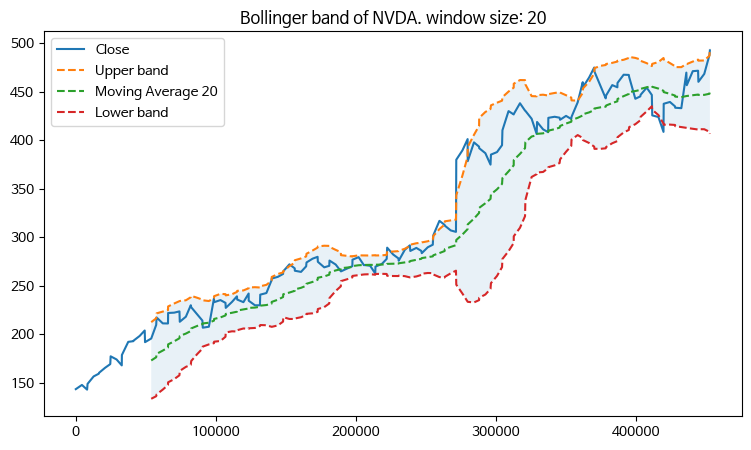

In [ ]:
plt.figure(figsize=(9, 5))
plt.plot(sample_df.index, sample_df['gts_iem_end_pr'], label='Close')
plt.plot(sample_df.index, sample_df['BoLL_high'], linestyle='dashed', label='Upper band')
plt.plot(sample_df.index, sample_df['BoLL_mid'], linestyle='dashed', label='Moving Average 20')
plt.plot(sample_df.index, sample_df['BoLL_low'], linestyle='dashed', label='Lower band')
plt.fill_between(sample_df.index, sample_df['BoLL_high'], sample_df['BoLL_low'], alpha=0.1)
plt.title(f"Bollinger band of {sample_df['tck_iem_cd'].unique()[0]}. window size: 20")
plt.legend(loc='best')

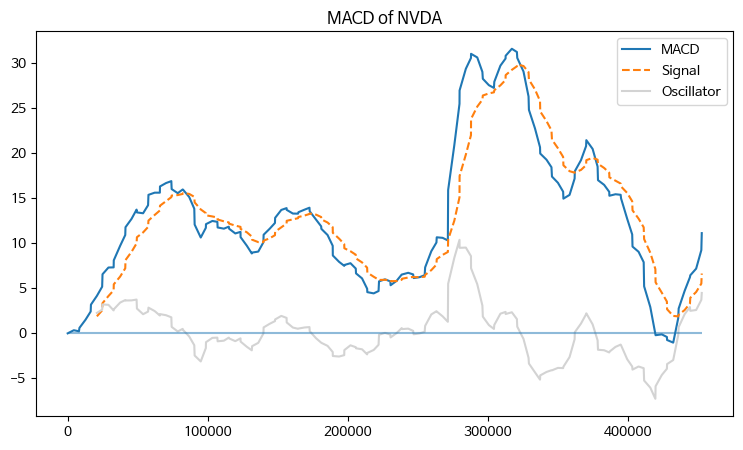

In [ ]:
plt.figure(figsize=(9, 5))
# plt.plot(sample_df.index, sample_df['gts_iem_end_pr'], label='Close')
plt.plot(sample_df.index, sample_df['MACD'], label='MACD')
plt.plot(sample_df.index, sample_df['MACD_signal'], linestyle='dashed', label='Signal')
plt.plot(sample_df.index, sample_df['MACD_oscil'], label='Oscillator', color='lightgrey')
plt.hlines(0, sample_df.index[0], sample_df.index[-1], alpha=0.5)
plt.title(f"MACD of {sample_df['tck_iem_cd'].unique()[0]}")
plt.legend(loc='best')

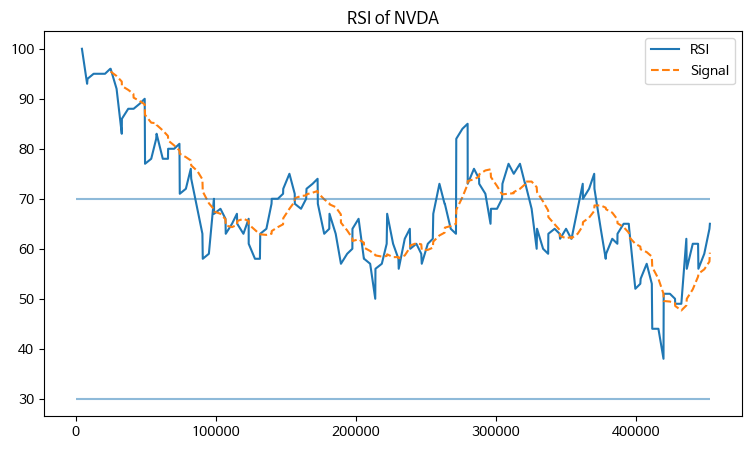

In [ ]:
plt.figure(figsize=(9, 5))
plt.plot(sample_df.index, sample_df['RSI'], label='RSI')
plt.plot(sample_df.index, sample_df['RSI_signal'], linestyle='dashed', label='Signal')
plt.hlines(30, sample_df.index[0], sample_df.index[-1], alpha=0.5)
plt.hlines(70, sample_df.index[0], sample_df.index[-1], alpha=0.5)
plt.title(f"RSI of {sample_df['tck_iem_cd'].unique()[0]}")
plt.legend(loc='best')

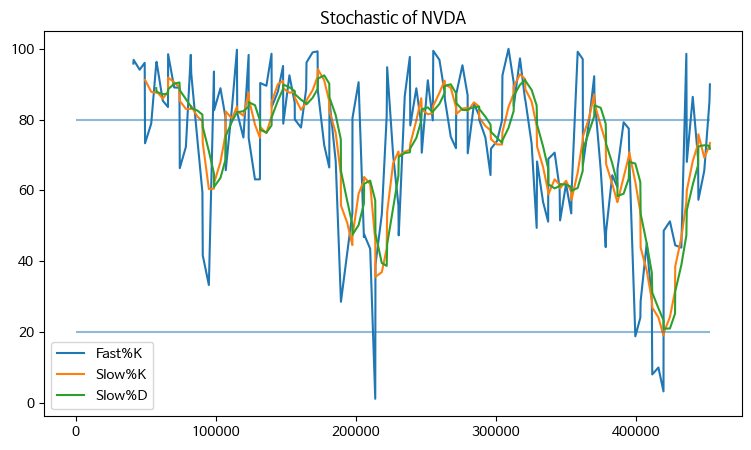

In [ ]:
plt.figure(figsize=(9, 5))
plt.plot(sample_df.index, sample_df['fast_K'], label='Fast%K')
plt.plot(sample_df.index, sample_df['slow_K'], label='Slow%K')
plt.plot(sample_df.index, sample_df['slow_D'], label='Slow%D')
plt.hlines(20, sample_df.index[0], sample_df.index[-1], alpha=0.5)
plt.hlines(80, sample_df.index[0], sample_df.index[-1], alpha=0.5)
plt.title(f"Stochastic of {sample_df['tck_iem_cd'].unique()[0]}")
plt.legend(loc='best')

+) turbulence 지표 추가

From FinRL package: https://github.com/AI4Finance-Foundation/FinRL/blob/master/finrl/meta/preprocessor/preprocessors.py#L206

In [ ]:
def calculate_turbulence(data):
    """calculate turbulence index based on dow 30"""

    df = data.copy()
    df_price_pivot = df.pivot(index='trd_dt', columns='tck_iem_cd', values='gts_iem_end_pr')
    df_price_pivot = df_price_pivot.pct_change()

    unique_date = df.trd_dt.unique()
    # start after a month
    start = 21
    turbulence_index = [0] * start
    count = 0
    for i in tqdm(range(start, len(unique_date))):
        current_price = df_price_pivot[df_price_pivot.index == unique_date[i]]
        # use one month rolling window to calcualte covariance
        hist_price = df_price_pivot[
            (df_price_pivot.index < unique_date[i])
            & (df_price_pivot.index >= unique_date[i - start])
        ]
        # Drop tickers which has number missing values more than the "oldest" ticker
        filtered_hist_price = hist_price.iloc[hist_price.isna().sum().min():].dropna(axis=1)

        cov_temp = filtered_hist_price.cov()
        current_temp = current_price[[x for x in filtered_hist_price]] - np.mean(filtered_hist_price, axis=0)

        temp = current_temp.values.dot(np.linalg.pinv(cov_temp)).dot(current_temp.values.T)
        if temp > 0:
            count += 1
            if count > 2:
                turbulence_temp = temp[0][0]
            else:
                # avoid large outlier because of the calculation just begins
                turbulence_temp = 0
        else:
            turbulence_temp = 0
        turbulence_index.append(turbulence_temp)
    turbulence_index = pd.DataFrame({'trd_dt': df_price_pivot.index, 'turbulence': turbulence_index})
    return turbulence_index

def add_turbulence(data):
    df = data.copy()
    turbulence_index = calculate_turbulence(df)
    df = df.merge(turbulence_index, on="trd_dt")
    df = df.sort_values(["trd_dt", "tck_iem_cd"]).reset_index(drop=True)
    return df

**피처 생성**

In [ ]:
# turbulence index부터 생성
df_with_tb = add_turbulence(df)

# 종목 별로 데이터프레임 분할
names = df_with_tb['tck_iem_cd'].unique()
df_per_name = [df_with_tb[df_with_tb['tck_iem_cd'] == name] for name in names]

# 종목 별로 기본지표 & 기술지표 생성
df_per_name_final = []
for df_i in df_per_name:
    df_i = get_technical_indicator(df_i)
    df_i = get_basic_indicators(df_i)
    df_per_name_final.append(df_i)

# concat all dataframes
df_final = pd.concat(df_per_name_final)
# reindex
df_final = df_final.sort_values(['tck_iem_cd', 'trd_dt']).reset_index(drop=True)

# save csv
df_final.to_csv('NASDAQ_Stock_data.csv', encoding='cp949', index=False)

100%|██████████| 145/145 [11:04<00:00,  4.59s/it]


In [ ]:
df_final

,trd_dt,tck_iem_cd,gts_iem_ong_pr,gts_iem_hi_pr,gts_iem_low_pr,gts_iem_end_pr,gts_acl_trd_qty,gts_sll_cns_sum_qty,gts_byn_cns_sum_qty,turbulence,...,std_price_month,avg_volume_week,avg_volume_month,std_volume_week,std_volume_month,return_1,return_week,return_month,return_ma_week,return_ma_month
0,20230103,AACG,1.22,1.3000,1.2200,1.2600,6972.0,420.0,6552.0,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN
1,20230104,AACG,1.28,1.2800,1.2500,1.2700,1350.0,0.0,1350.0,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN
2,20230105,AACG,1.24,1.3665,1.2400,1.3210,2307.0,980.0,1327.0,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,0.007937,0.000000,0.000000,NaN,NaN
3,20230106,AACG,1.36,1.4400,1.3543,1.4123,1314.0,657.0,657.0,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,0.040157,0.000000,0.000000,NaN,NaN
4,20230109,AACG,1.42,1.4767,1.4000,1.4000,7422.0,1212.0,6210.0,0.000000e+00,...,NaN,3873.0,NaN,3064.537812,NaN,0.069114,0.000000,0.000000,0.023442,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455333,20230824,ZYXI,8.02,8.0200,7.6500,7.7500,268578.0,170630.0,97948.0,8.339505e+00,...,0.732384,275789.6,333038.857143,36862.802502,158983.702188,0.005013,0.060847,-0.150424,0.011921,-0.007226
455334,20230825,ZYXI,7.74,7.7700,7.5100,7.7000,179197.0,81549.0,97648.0,2.240631e+01,...,0.646207,255064.4,327993.571429,56054.564750,162227.553297,-0.033666,0.014398,-0.190178,0.003071,-0.009485
455335,20230828,ZYXI,7.70,7.7700,7.5700,7.6600,200784.0,104724.0,96060.0,0.000000e+00,...,0.504455,230575.0,321928.952381,44355.044313,164585.154648,-0.006452,0.002604,-0.210256,0.000733,-0.010688
455336,20230829,ZYXI,7.65,7.7400,7.5500,7.7100,247955.0,124040.0,123915.0,2.454570e+11,...,0.303054,223463.2,323634.476190,35763.521942,163573.024909,-0.005195,-0.030380,-0.225480,-0.006035,-0.011619


In [ ]:
# Crawling stock info from KRX 정보데이터시스템
total = []
tk_ori = {}
ms = {}
md = {}


df1 = pd.read_csv('./data_5155_20230916.csv', encoding='cp949')
df2 = pd.read_csv('./data_5206_20230916.csv', encoding='cp949')

df1['상장일'] = pd.to_datetime(df1['상장일']).dt.strftime('%Y%m%d').astype('int32')
df2['상장일'] = pd.to_datetime(df2['상장일']).dt.strftime('%Y%m%d').astype('int32')

In [ ]:
df1

,표준코드,단축코드,한글 종목명,한글 종목약명,영문 종목명,상장일,시장구분,증권구분,소속부,주식종류,액면가,상장주식수
0,KR7095570008,095570,AJ네트웍스보통주,AJ네트웍스,"AJ Networks Co.,Ltd.",20150821,KOSPI,주권,NaN,보통주,1000,46822295
1,KR7006840003,006840,AK홀딩스보통주,AK홀딩스,"AK Holdings, Inc.",19990811,KOSPI,주권,NaN,보통주,5000,13247561
2,KR7282330000,282330,BGF리테일보통주,BGF리테일,BGF Retail,20171208,KOSPI,주권,NaN,보통주,1000,17283906
3,KR7027410000,027410,BGF보통주,BGF,BGF,20140519,KOSPI,주권,NaN,보통주,1000,95716791
4,KR7138930003,138930,BNK금융지주보통주,BNK금융지주,BNK Financial Group Inc.,20110330,KOSPI,주권,NaN,보통주,5000,322088438
...,...,...,...,...,...,...,...,...,...,...,...,...
946,KR7079980009,079980,휴비스보통주,휴비스,HUVIS,20120223,KOSPI,주권,NaN,보통주,5000,34500000
947,KR7005010004,005010,휴스틸보통주,휴스틸,HUSTEEL,19730629,KOSPI,주권,NaN,보통주,1000,56188075
948,KR7000541003,000545,흥국화재해상보험1우선주,흥국화재우,HeungkukFire&MarineIns(1P),19900320,KOSPI,주권,NaN,구형우선주,5000,768000
949,KR7000540005,000540,흥국화재해상보험보통주,흥국화재,HeungkukFire&MarineInsurance,19741205,KOSPI,주권,NaN,보통주,5000,64242645


In [ ]:
df1 = df1[df1['상장일'] <= 20230101]
df2 = df2[df2['상장일'] <= 20230101]

tickers = df1['단축코드'].values.tolist()
tickers += df2['단축코드'].values.tolist()

In [ ]:
df1

,표준코드,단축코드,한글 종목명,한글 종목약명,영문 종목명,상장일,시장구분,증권구분,소속부,주식종류,액면가,상장주식수
0,KR7095570008,095570,AJ네트웍스보통주,AJ네트웍스,"AJ Networks Co.,Ltd.",20150821,KOSPI,주권,NaN,보통주,1000,46822295
1,KR7006840003,006840,AK홀딩스보통주,AK홀딩스,"AK Holdings, Inc.",19990811,KOSPI,주권,NaN,보통주,5000,13247561
2,KR7282330000,282330,BGF리테일보통주,BGF리테일,BGF Retail,20171208,KOSPI,주권,NaN,보통주,1000,17283906
3,KR7027410000,027410,BGF보통주,BGF,BGF,20140519,KOSPI,주권,NaN,보통주,1000,95716791
4,KR7138930003,138930,BNK금융지주보통주,BNK금융지주,BNK Financial Group Inc.,20110330,KOSPI,주권,NaN,보통주,5000,322088438
...,...,...,...,...,...,...,...,...,...,...,...,...
946,KR7079980009,079980,휴비스보통주,휴비스,HUVIS,20120223,KOSPI,주권,NaN,보통주,5000,34500000
947,KR7005010004,005010,휴스틸보통주,휴스틸,HUSTEEL,19730629,KOSPI,주권,NaN,보통주,1000,56188075
948,KR7000541003,000545,흥국화재해상보험1우선주,흥국화재우,HeungkukFire&MarineIns(1P),19900320,KOSPI,주권,NaN,구형우선주,5000,768000
949,KR7000540005,000540,흥국화재해상보험보통주,흥국화재,HeungkukFire&MarineInsurance,19741205,KOSPI,주권,NaN,보통주,5000,64242645


In [ ]:
tickers

['095570',
 '006840',
 '282330',
 '027410',
 '138930',
 '001465',
 '001460',
 '001045',
 '00104K',
 '001040',
 '011155',
 '011150',
 '000590',
 '012030',
 '016610',
 '005830',
 '000990',
 '139130',
 '001530',
 '000215',
 '001880',
 '000210',
 '37550K',
 '37550L',
 '375500',
 '155660',
 '069730',
 '017940',
 '365550',
 '383220',
 '007700',
 '078935',
 '006360',
 '078930',
 '012630',
 '294870',
 '097230',
 '014790',
 '204320',
 '060980',
 '035000',
 '003560',
 '175330',
 '234080',
 '001065',
 '001067',
 '001060',
 '096760',
 '105560',
 '432320',
 '009070',
 '003620',
 '016380',
 '001390',
 '033180',
 '001940',
 '025000',
 '092230',
 '000040',
 '093050',
 '003555',
 '034220',
 '003550',
 '051905',
 '051900',
 '373220',
 '032640',
 '011070',
 '066575',
 '066570',
 '051915',
 '051910',
 '079550',
 '010120',
 '000680',
 '006260',
 '108320',
 '001120',
 '023150',
 '035420',
 '181710',
 '338100',
 '034310',
 '008260',
 '004255',
 '004250',
 '010955',
 '010950',
 '005090',
 '001380',
 '001770',

In [ ]:
red = pd.read_csv('./data_.csv', encoding='cp949')
stopped = red[red['매매거래정지']=='O']['종목코드'].values.tolist()

In [ ]:
red

,종목코드,종목명,매매거래정지,정리매매 종목,관리종목,투자주의환기종목,불성실공시,단일가매매대상 초저유동성종목,상장주식수 부족 우선주,단기과열종목,투자주의종목,투자경고종목,투자위험종목
0,060310,3S,X,X,X,X,X,X,X,X,X,X,X
1,095570,AJ네트웍스,X,X,X,X,O,X,X,X,X,X,X
2,006840,AK홀딩스,X,X,X,X,X,X,X,X,X,X,X
3,054620,APS,X,X,X,X,X,X,X,X,X,X,X
4,265520,AP시스템,X,X,X,X,X,X,X,X,X,X,X
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2753,000540,흥국화재,X,X,X,X,X,X,X,X,X,X,X
2754,000545,흥국화재우,X,X,X,X,X,O,X,O,X,X,X
2755,003280,흥아해운,X,X,X,X,X,X,X,X,X,X,X
2756,037440,희림,X,X,X,X,X,X,X,X,X,X,X


In [ ]:
stopped

['426550',
 '003560',
 '099520',
 '226360',
 '111870',
 '033180',
 '038340',
 '014200',
 '397880',
 '078130',
 '229500',
 '106520',
 '065560',
 '214870',
 '006580',
 '290380',
 '000300',
 '032860',
 '227420',
 '141020',
 '163430',
 '001080',
 '054180',
 '257370',
 '001340',
 '066410',
 '299910',
 '206950',
 '005030',
 '121800',
 '148140',
 '030790',
 '007610',
 '091090',
 '268600',
 '068940',
 '136510',
 '269620',
 '419270',
 '393360',
 '102280',
 '286000',
 '058220',
 '117670',
 '263540',
 '217480',
 '121890',
 '214310',
 '299670',
 '435870',
 '089530',
 '015540',
 '391060',
 '438580',
 '093510',
 '208860',
 '138690',
 '071460',
 '077500',
 '373340',
 '388800',
 '056090',
 '093230',
 '181340',
 '160600',
 '096040',
 '024810',
 '101140',
 '150840',
 '178780',
 '008500',
 '174880',
 '052670',
 '044060',
 '033340',
 '219750',
 '012600',
 '047820',
 '016790',
 '109070',
 '436530',
 '069110',
 '114120',
 '110790',
 '062860',
 '058530',
 '318020',
 '150440',
 '057880',
 '448370',
 '427950',

In [ ]:
tickers = list(set(tickers) - set(stopped))
# 20230101 전에 올린 종목들에 대해서 매매거래정지는 뺌.

In [ ]:
tickers

['002450',
 '396690',
 '074610',
 '033790',
 '053080',
 '009240',
 '030210',
 '003620',
 '091120',
 '026940',
 '179290',
 '131100',
 '003480',
 '321820',
 '048870',
 '237820',
 '044180',
 '137940',
 '036420',
 '151910',
 '065530',
 '093640',
 '208710',
 '304100',
 '214430',
 '163730',
 '104200',
 '037560',
 '056700',
 '402340',
 '237690',
 '014790',
 '039860',
 '006405',
 '016740',
 '301300',
 '001515',
 '086390',
 '300720',
 '317330',
 '096690',
 '336260',
 '029530',
 '225530',
 '122900',
 '100590',
 '298040',
 '148930',
 '002380',
 '098120',
 '098460',
 '161570',
 '133750',
 '120110',
 '276040',
 '330590',
 '001810',
 '001685',
 '014470',
 '090370',
 '213500',
 '101330',
 '058610',
 '241560',
 '422040',
 '099190',
 '079370',
 '311320',
 '050760',
 '200780',
 '016670',
 '111710',
 '058650',
 '421800',
 '007120',
 '251120',
 '115570',
 '333620',
 '000990',
 '123840',
 '230240',
 '009140',
 '000120',
 '271560',
 '115440',
 '000215',
 '065370',
 '018000',
 '020760',
 '337930',
 '082800',

In [ ]:
df

,trd_dt,tck_iem_cd,gts_iem_ong_pr,gts_iem_hi_pr,gts_iem_low_pr,gts_iem_end_pr,gts_acl_trd_qty,gts_sll_cns_sum_qty,gts_byn_cns_sum_qty
0,20230103,NVDA,148.5100,149.9600,140.9600,143.1500,40127658.0,0.0,0.0
1,20230103,APLT,0.7535,0.7900,0.7308,0.7522,63714.0,19658.0,44056.0
2,20230103,ANY,1.8900,2.0293,1.8354,1.9600,24896.4,0.0,0.0
3,20230103,CLRB,1.6600,1.7200,1.6300,1.6300,21212.0,16444.0,4768.0
4,20230103,NYMTM,18.4300,18.7400,18.4300,18.7000,8061.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
455333,20230830,BLZE,5.9900,6.1290,5.8300,5.8600,443470.0,205162.0,238308.0
455334,20230830,ELDN,1.4800,1.5794,1.4100,1.4900,13462.0,5492.0,7970.0
455335,20230830,BMBL,15.9000,16.4400,15.7900,16.3200,1030250.0,576506.0,453744.0
455336,20230830,PLRX,16.7900,16.7900,16.2250,16.7100,319531.0,138554.0,180977.0


In [ ]:
# 한개의 티커 코드로 테스트하기 위해 첫 번째 티커를 선택
t = tickers[0]

# 데이터 가져오기
df_sampleee = stock.get_market_ohlcv('20230103', '20230831', t)

# 컬럼 추가
df_sampleee['tck_iem_cd'] = t
df_sampleee['tickers_kor_code'] = t  # 'tickers_kor_code' 컬럼 추가
df_sampleee.reset_index(inplace=True)
df_sampleee = df_sampleee.rename(columns={"날짜":'trd_dt', "시가": "gts_iem_ong_pr", '고가':'gts_iem_hi_pr', '저가':'gts_iem_low_pr', '종가':'gts_iem_end_pr','거래량':'gts_acl_trd_qty'})
df_sampleee = df_sampleee.drop(['등락률'], axis=1)

# 매수, 매도 거래량 계산
try:
    ms[t] = int(stock.get_market_trading_value_by_date('20230103', '20230831', t, on='매수')['전체'].values)
    md[t] = int(stock.get_market_trading_value_by_date('20230103', '20230831', t, on='매도')['전체'].values)
except:
    ms[t] = 0
    md[t] = 0

# 매수, 매도 거래량 컬럼 추가
df_sampleee['gts_sll_cns_sum_qty'] = df_sampleee['tck_iem_cd'].map(md)
df_sampleee['gts_byn_cns_sum_qty'] = df_sampleee['tck_iem_cd'].map(ms)

# 컬럼 순서 변경
cols = ['trd_dt', 'tck_iem_cd', 'tickers_kor_code', 'gts_iem_ong_pr', 'gts_iem_hi_pr', 'gts_iem_low_pr', 'gts_iem_end_pr', 'gts_acl_trd_qty', 'gts_sll_cns_sum_qty', 'gts_byn_cns_sum_qty']
df_sampleee = df_sampleee[cols]
df_sampleee

,trd_dt,tck_iem_cd,tickers_kor_code,gts_iem_ong_pr,gts_iem_hi_pr,gts_iem_low_pr,gts_iem_end_pr,gts_acl_trd_qty,gts_sll_cns_sum_qty,gts_byn_cns_sum_qty
0,2023-01-03,002450,002450,1220,1255,1210,1245,132204,0,0
1,2023-01-04,002450,002450,1230,1255,1230,1250,49391,0,0
2,2023-01-05,002450,002450,1250,1260,1215,1220,342767,0,0
3,2023-01-06,002450,002450,1215,1240,1215,1240,109860,0,0
4,2023-01-09,002450,002450,1245,1275,1245,1270,189543,0,0
...,...,...,...,...,...,...,...,...,...,...
160,2023-08-25,002450,002450,1122,1124,1118,1123,22521,0,0
161,2023-08-28,002450,002450,1118,1132,1118,1122,23508,0,0
162,2023-08-29,002450,002450,1123,1132,1123,1131,55243,0,0
163,2023-08-30,002450,002450,1131,1134,1130,1130,10318,0,0


In [ ]:
kor_data = pd.read_csv('kor_data_rev.csv',encoding = 'cp949')
kor_data
#tck_iem_cd 는 티커코드
#문제점 : kor_data_rev가 gts_sll_cns_sum_qty 매도체결합계수량	gts_byn_cns_sum_qty 매수체결합계수량이 안나와...

C:\Users\82109\AppData\Local\Temp\ipykernel_7292\3011198649.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  kor_data = pd.read_csv('kor_data_rev.csv',encoding = 'cp949')


,trd_dt,tck_iem_cd,gts_iem_ong_pr,gts_iem_hi_pr,gts_iem_low_pr,gts_iem_end_pr,gts_acl_trd_qty,gts_sll_cns_sum_qty,gts_byn_cns_sum_qty
0,2023-01-03,002360,800,810,782,809,884643,0,0
1,2023-01-04,002360,781,830,781,813,668207,0,0
2,2023-01-05,002360,814,821,806,807,469538,0,0
3,2023-01-06,002360,802,828,800,824,658778,0,0
4,2023-01-09,002360,828,836,828,832,388273,0,0
...,...,...,...,...,...,...,...,...,...
401770,2023-08-25,3960,29100,29400,28650,29000,23195,0,0
401771,2023-08-28,3960,28750,29150,28600,28950,15815,0,0
401772,2023-08-29,3960,28700,29100,28700,28900,12191,0,0
401773,2023-08-30,3960,28900,28950,28200,28200,16815,0,0


In [ ]:
dfkor = kor_data.copy()
dfkor.isnull().sum()

trd_dt                 0
tck_iem_cd             0
gts_iem_ong_pr         0
gts_iem_hi_pr          0
gts_iem_low_pr         0
gts_iem_end_pr         0
gts_acl_trd_qty        0
gts_sll_cns_sum_qty    0
gts_byn_cns_sum_qty    0
dtype: int64

In [ ]:
len(dfkor['tck_iem_cd'].unique())

2436

### 나온  지표들
* def get_basic_indicators(df, week=5, month=21): 과거 n일 평균종가,거래량,표준편차 등
* def get_boll(price,n=20):볼린저밴드
* def get_macd(price,n=9):이동평균 수렴확산지수
* def get_rsi(price,n1=14,n2=9):상대강도지수
* def get_stochastic(high,low,close,n=15, m=5, t=3):스토캐스틱지표
* def get_technical_indicator(df):위에 bol부터 스토캐스틱가지를 전부해서 보여줌.
* def calculate_turbulence(data):: turbulence 지표
* def add_turbulence(data): turbulence 기존 df에 더하는.

In [ ]:
sample_kor_df = dfkor[dfkor['tck_iem_cd']==dfkor['tck_iem_cd'].unique()[0]]
sample_kor_df # 002360코드에 대해 분석.

,trd_dt,tck_iem_cd,gts_iem_ong_pr,gts_iem_hi_pr,gts_iem_low_pr,gts_iem_end_pr,gts_acl_trd_qty,gts_sll_cns_sum_qty,gts_byn_cns_sum_qty
0,2023-01-03,002360,800,810,782,809,884643,0,0
1,2023-01-04,002360,781,830,781,813,668207,0,0
2,2023-01-05,002360,814,821,806,807,469538,0,0
3,2023-01-06,002360,802,828,800,824,658778,0,0
4,2023-01-09,002360,828,836,828,832,388273,0,0
...,...,...,...,...,...,...,...,...,...
160,2023-08-25,002360,653,657,645,645,182132,0,0
161,2023-08-28,002360,646,671,646,670,551292,0,0
162,2023-08-29,002360,672,679,665,669,418939,0,0
163,2023-08-30,002360,675,675,664,671,328876,0,0


In [ ]:
sample_kor_df = get_technical_indicator(sample_kor_df)
sample_kor_df

,trd_dt,tck_iem_cd,gts_iem_ong_pr,gts_iem_hi_pr,gts_iem_low_pr,gts_iem_end_pr,gts_acl_trd_qty,gts_sll_cns_sum_qty,gts_byn_cns_sum_qty,BoLL_low,BoLL_mid,BoLL_high,MACD,MACD_signal,MACD_oscil,RSI,RSI_signal,fast_K,slow_K,slow_D
0,2023-01-03,002360,800,810,782,809,884643,0,0,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-01-04,002360,781,830,781,813,668207,0,0,NaN,NaN,NaN,0.319088,NaN,NaN,100.0,NaN,NaN,NaN,NaN
2,2023-01-05,002360,814,821,806,807,469538,0,0,NaN,NaN,NaN,0.086817,NaN,NaN,91.0,NaN,NaN,NaN,NaN
3,2023-01-06,002360,802,828,800,824,658778,0,0,NaN,NaN,NaN,1.259975,NaN,NaN,93.0,NaN,NaN,NaN,NaN
4,2023-01-09,002360,828,836,828,832,388273,0,0,NaN,NaN,NaN,2.802933,NaN,NaN,94.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,2023-08-25,002360,653,657,645,645,182132,0,0,620.757228,656.25,691.742772,-12.966307,-14.903185,1.936878,43.0,40.666667,32.954545,34.090909,29.396940
161,2023-08-28,002360,646,671,646,670,551292,0,0,622.175358,657.60,693.024642,-10.452002,-14.012948,3.560946,51.0,41.222222,61.363636,41.363636,35.000000
162,2023-08-29,002360,672,679,665,669,418939,0,0,622.175358,657.60,693.024642,-8.442765,-12.898911,4.456146,51.0,42.555556,60.227273,47.045455,40.833333
163,2023-08-30,002360,675,675,664,671,328876,0,0,622.175358,657.60,693.024642,-6.612819,-11.641693,5.028874,52.0,44.555556,62.500000,52.954545,47.121212


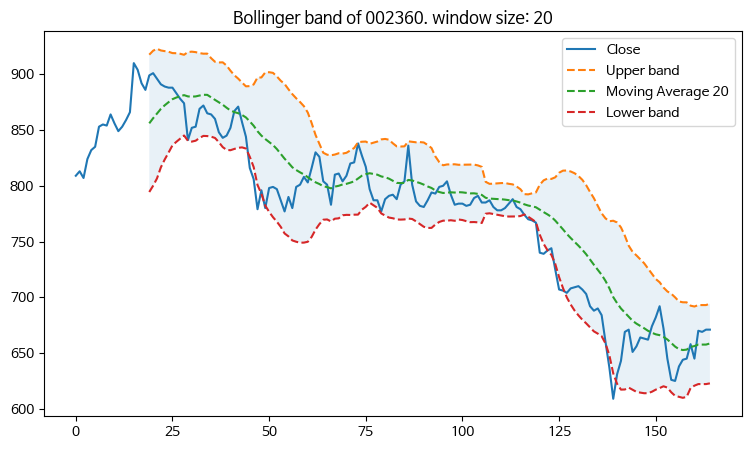

In [ ]:
plt.figure(figsize=(9, 5))
plt.plot(sample_kor_df.index, sample_kor_df['gts_iem_end_pr'], label='Close')
plt.plot(sample_kor_df.index, sample_kor_df['BoLL_high'], linestyle='dashed', label='Upper band')
plt.plot(sample_kor_df.index, sample_kor_df['BoLL_mid'], linestyle='dashed', label='Moving Average 20')
plt.plot(sample_kor_df.index, sample_kor_df['BoLL_low'], linestyle='dashed', label='Lower band')
plt.fill_between(sample_kor_df.index, sample_kor_df['BoLL_high'], sample_kor_df['BoLL_low'], alpha=0.1)
plt.title(f"Bollinger band of {sample_kor_df['tck_iem_cd'].unique()[0]}. window size: 20")
plt.legend(loc='best')
# bollinger

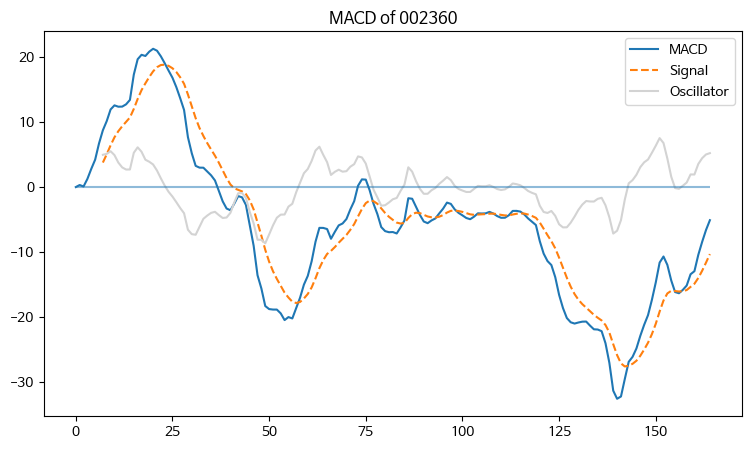

In [ ]:
plt.figure(figsize=(9, 5))
# plt.plot(sample_df.index, sample_df['gts_iem_end_pr'], label='Close')
plt.plot(sample_kor_df.index, sample_kor_df['MACD'], label='MACD')
plt.plot(sample_kor_df.index, sample_kor_df['MACD_signal'], linestyle='dashed', label='Signal')
plt.plot(sample_kor_df.index, sample_kor_df['MACD_oscil'], label='Oscillator', color='lightgrey')
plt.hlines(0, sample_kor_df.index[0], sample_kor_df.index[-1], alpha=0.5)
plt.title(f"MACD of {sample_kor_df['tck_iem_cd'].unique()[0]}")
plt.legend(loc='best')
# MACD

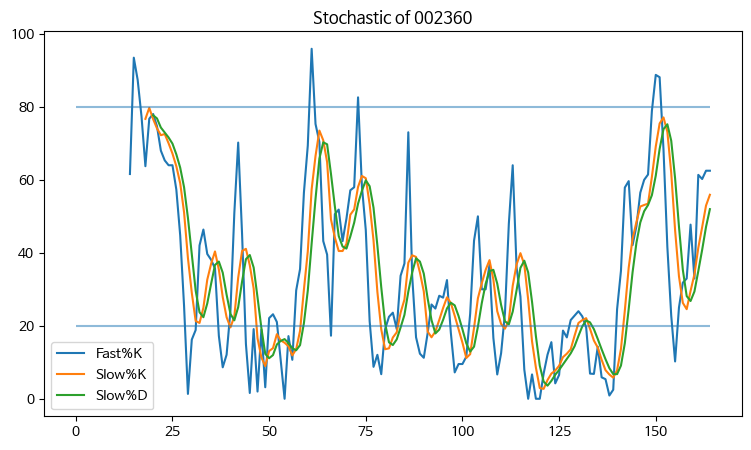

In [ ]:
plt.figure(figsize=(9, 5))
plt.plot(sample_kor_df.index, sample_kor_df['fast_K'], label='Fast%K')
plt.plot(sample_kor_df.index, sample_kor_df['slow_K'], label='Slow%K')
plt.plot(sample_kor_df.index, sample_kor_df['slow_D'], label='Slow%D')
plt.hlines(20, sample_kor_df.index[0], sample_kor_df.index[-1], alpha=0.5)
plt.hlines(80, sample_kor_df.index[0], sample_kor_df.index[-1], alpha=0.5)
plt.title(f"Stochastic of {sample_kor_df['tck_iem_cd'].unique()[0]}")
plt.legend(loc='best')

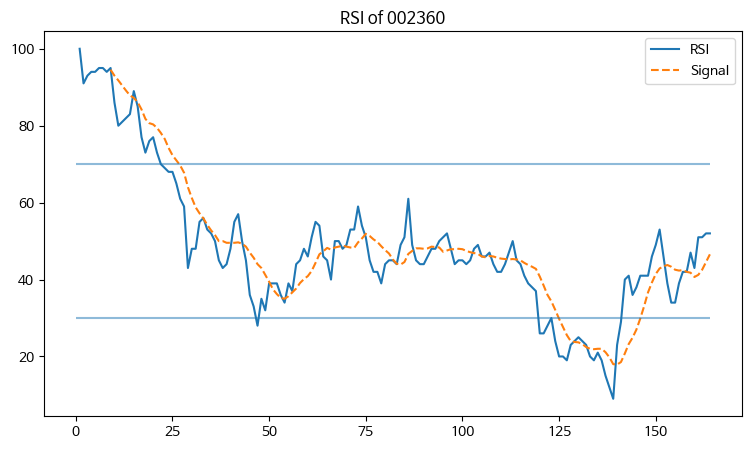

In [ ]:
plt.figure(figsize=(9, 5))
plt.plot(sample_kor_df.index, sample_kor_df['RSI'], label='RSI')
plt.plot(sample_kor_df.index, sample_kor_df['RSI_signal'], linestyle='dashed', label='Signal')
plt.hlines(30, sample_kor_df.index[0], sample_kor_df.index[-1], alpha=0.5)
plt.hlines(70, sample_kor_df.index[0], sample_kor_df.index[-1], alpha=0.5)
plt.title(f"RSI of {sample_kor_df['tck_iem_cd'].unique()[0]}")
plt.legend(loc='best')

In [ ]:
# turbulence index부터 생성
dfkor_with_tb = add_turbulence(dfkor)

# 종목 별로 데이터프레임 분할
nameskor = dfkor_with_tb['tck_iem_cd'].unique()
dfkor_per_name = [dfkor_with_tb[dfkor_with_tb['tck_iem_cd'] == name] for name in nameskor]

# 종목 별로 기본지표 & 기술지표 생성
dfkor_per_name_final = []
for dfkor_i in dfkor_per_name:
    dfkor_i = get_technical_indicator(dfkor_i)
    dfkor_i = get_basic_indicators(dfkor_i)
    dfkor_per_name_final.append(dfkor_i)

# concat all dataframes
dfkor_final = pd.concat(dfkor_per_name_final)
# reindex
dfkor_final = dfkor_final.sort_values(['tck_iem_cd', 'trd_dt']).reset_index(drop=True)

# save csv
dfkor_final.to_csv('KOREA_Stock_data.csv', encoding='cp949', index=False)

100%|██████████| 144/144 [06:48<00:00,  2.84s/it]
